In [23]:
using Statistics, LinearAlgebra, Plots, CSV, DataFrames, Polynomials

#### Zadanie 1

In [ ]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

naive_multiplication (generic function with 1 method)

In [25]:
# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

better_multiplication (generic function with 1 method)

In [26]:
function better_multiplication_mine(A, B)
    n = size(A,1)
    B = copy(transpose(B))  # prawdziwa transpozycja
    C = zeros(Float64, n, n)
    for i in 1:n
        for j in 1:n
            sum = 0.0
            @inbounds for k in 1:n
                sum += A[i,k] * B[j,k]
            end
            C[i,j] = sum
        end
    end
    return C
end

better_multiplication_mine (generic function with 1 method)

In [27]:
function BLAS_multiplication(A, B)
    n = size(A,1)
    C = zeros(n,n)
    BLAS.gemm!('N', 'N', 1.0, A, B, 0.0, C)
    return C
end

BLAS_multiplication (generic function with 1 method)

Test czasów

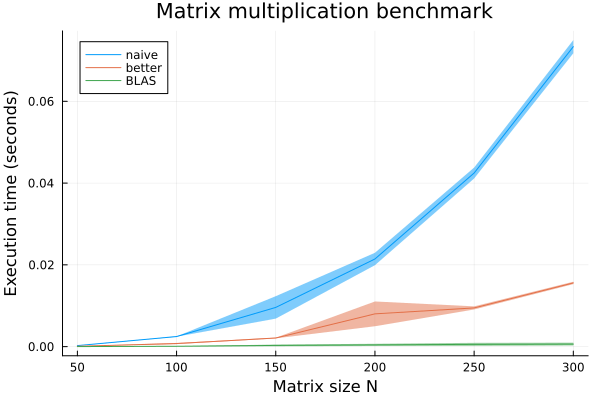

In [28]:
function benchmark_function(f, A, B)
    times = [@elapsed f(A,B) for _ in 1:11]
    times = times[2:end]
    return mean(times), std(times)
end

sizes = 50:50:300

naive_means = Float64[]
naive_stds = Float64[]

better_means = Float64[]
better_stds = Float64[]

blas_means = Float64[]
blas_stds = Float64[]

for n in sizes
    A = randn(n, n)
    B = randn(n, n)

    μ, σ = benchmark_function(naive_multiplication, A, B)
    push!(naive_means, μ)
    push!(naive_stds, σ)

    μ, σ = benchmark_function(better_multiplication, A, B)
    push!(better_means, μ)
    push!(better_stds, σ)

    μ, σ = benchmark_function(BLAS_multiplication, A, B)
    push!(blas_means, μ)
    push!(blas_stds, σ)
end

plot()
plot!(sizes, naive_means, ribbon=naive_stds, label="naive")
plot!(sizes, better_means, ribbon=better_stds, label="better")
plot!(sizes, blas_means, ribbon=blas_stds, label="BLAS")

xlabel!("Matrix size N")
ylabel!("Execution time (seconds)")
title!("Matrix multiplication benchmark")


#### Zadanie 2

Kod źródłowy

```c
void naive_multiplication(double** A, double** B, double** C, int size){
    for (int i = 0; i < size;i++){
        for (int j = 0; j < size; j++){
            for (int k = 0; k < size; k ++){
                C[i][j] += A[i][k]*B[k][j];
            }
        }
    }
}

void better_multiplication(double** A, double** B, double** C, int size){
    for (int i = 0; i < size; i++){
        for (int k = 0; k < size; k ++){
            for (int j = 0; j < size; j++){
                C[i][j] += A[i][k]*B[k][j];
            }
        }
    }
}

#include <gsl/gsl_blas.h>
#include <gsl/gsl_matrix.h>

void flatten_matrix(double **src, double *dest, int n) {
    for (int i = 0; i < n; i++)
        for (int j = 0; j < n; j++)
            dest[i * n + j] = src[i][j];
}

void BLAS_multiplication(double** A, double** B, double** C, int n) {
    double *A_flat = malloc(n * n * sizeof(double));
    double *B_flat = malloc(n * n * sizeof(double));
    double *C_flat = malloc(n * n * sizeof(double));

    flatten_matrix(A, A_flat, n);
    flatten_matrix(B, B_flat, n);

    gsl_matrix_view Am = gsl_matrix_view_array(A_flat, n, n);
    gsl_matrix_view Bm = gsl_matrix_view_array(B_flat, n, n);
    gsl_matrix_view Cm = gsl_matrix_view_array(C_flat, n, n);

    gsl_blas_dgemm(CblasNoTrans, CblasNoTrans,
                   1.0, &Am.matrix, &Bm.matrix,
                   0.0, &Cm.matrix);

    for (int i = 0; i < n; i++)
        for (int j = 0; j < n; j++)
            C[i][j] = C_flat[i * n + j];

    free(A_flat);
    free(B_flat);
    free(C_flat);
}


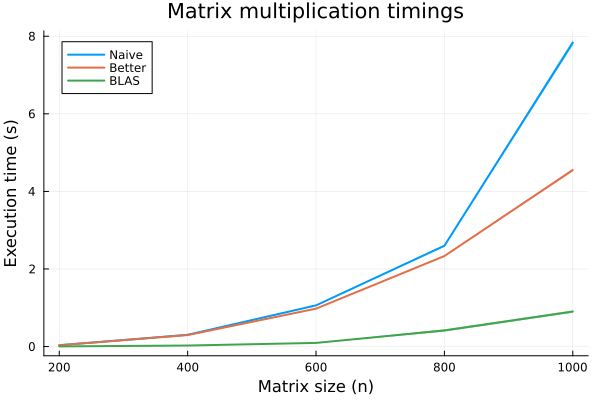

In [29]:
path = "C:\\msys64\\home\\icefr\\matrixMultiplicationC"

function load_and_analyze(filename)
    df = CSV.read(joinpath(path, filename), DataFrame, header=false)
    rename!(df, [:size, :time])
    return combine(groupby(df, :size),
                   :time => mean => :mean,
                   :time => std => :std)
end

naive_stats = load_and_analyze("naive.csv")
better_stats = load_and_analyze("better.csv")
blas_stats = load_and_analyze("blas.csv")

plot(naive_stats.size, naive_stats.mean; ribbon=naive_stats.std, label="Naive", lw=2)
plot!(better_stats.size, better_stats.mean; ribbon=better_stats.std, label="Better", lw=2)
plot!(blas_stats.size, blas_stats.mean; ribbon=blas_stats.std, label="BLAS", lw=2)

xlabel!("Matrix size (n)")
ylabel!("Execution time (s)")
title!("Matrix multiplication timings")


#### Zadanie 4

Aproksymacja funkcji naiwnego algorytmu

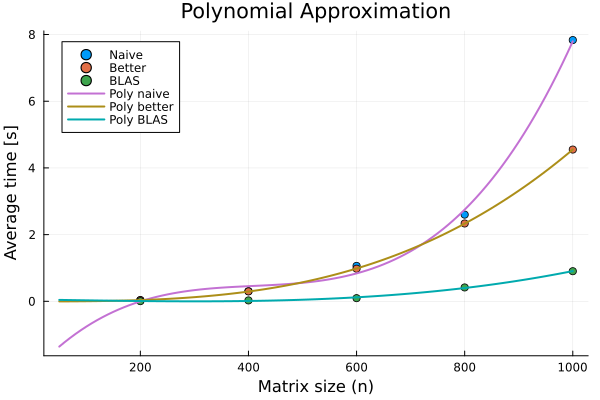

In [33]:
poly_naive = fit(naive_stats.size, naive_stats.mean, 3)
poly_better = fit(better_stats.size, better_stats.mean, 3)
poly_blas = fit(blas_stats.size, blas_stats.mean, 3)

plot(naive_stats.size, naive_stats.mean; label="Naive", seriestype=:scatter)
plot!(better_stats.size, better_stats.mean; label="Better", seriestype=:scatter)
plot!(blas_stats.size, blas_stats.mean; label="BLAS", seriestype=:scatter)

xs = 50:10:1000
plot!(xs,poly_naive.(xs); label="Poly naive", lw=2)
plot!(xs,poly_better.(xs); label="Poly better", lw=2)
plot!(xs,poly_blas.(xs); label="Poly BLAS", lw=2)

xlabel!("Matrix size (n)")
ylabel!("Average time [s]")
title!("Polynomial Approximation")

#### Zadanie 4

$$
x_k = \frac{a + b}{2} + \frac{b - a}{2} \cos\left( \frac{2k - 1}{2n} \pi \right), \quad \text{dla } k = 1, 2, \dots, n
$$

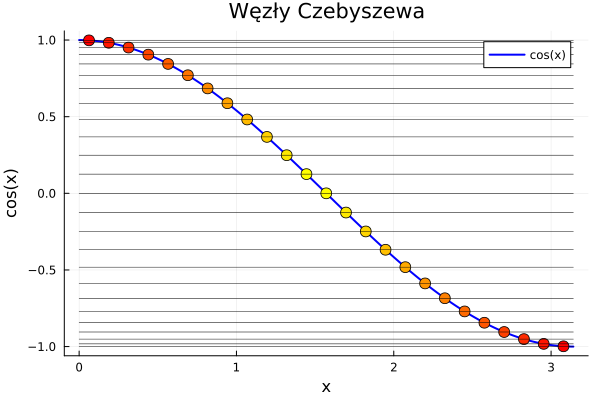

In [ ]:
f(x) = exp(-x^2)

# Bounds
a = -5
b = 5

x_plot = LinRange(a, b, 1000)
f_plot = f.(x_plot)

function chebyshev_nodes(n, a, b)
    return [(a + b)/2 + (b - a)/2 * cos((2k - 1) * π / (2n)) for k in 1:n]
end

Ns = [5, 10, 15, 20, 25, 30]

colors = [:orange, :green]
labels = ["Równoodległe", "Czebyszew"]

for N in Ns
    # uniform
    x_uniform = LinRange(a, b, N)
    y_uniform = f.(x_uniform)
    p_uniform = fit(x_uniform, y_uniform)

    # czebyszew
    x_cheb = chebyshev_nodes(N, a, b)
    y_cheb = f.(x_cheb)
    p_cheb = fit(x_cheb, y_cheb)

    y_approx_uniform = p_uniform.(x_plot)
    y_approx_cheb = p_cheb.(x_plot)

    p = plot(x_plot, f_plot, linestyle=:dash, color=:red, label="f(x) = exp(-x²)", linewidth=2)
    plot!(p, x_plot, y_approx_uniform, color=colors[1], label=labels[1], linewidth=2)
    plot!(p, x_plot, y_approx_cheb, color=colors[2], label=labels[2], linewidth=2)
    scatter!(p, x_uniform, y_uniform, color=colors[1], label="", markersize=3)
    scatter!(p, x_cheb, y_cheb, color=colors[2], label="", markersize=3)

    title!(p, "Interpolacja dla N = $N")
    xlabel!(p, "x")
    ylabel!(p, "f(x)")

    savefig(p, "regVSczerb/interpolacja_N=$N.png")
end


Wyniki porównania

| ![N=5](regVSczerb/interpolacja_N=5.png)  | ![N=10](regVSczerb/interpolacja_N=10.png) |
|---------------------------------|---------------------------------|
| ![N=15](regVSczerb/interpolacja_N=15.png) | ![N=20](regVSczerb/interpolacja_N=20.png) |
| ![N=25](regVSczerb/interpolacja_N=25.png) | ![N=30](regVSczerb/interpolacja_N=30.png) |


#### Zadanie 5

**Funkcje użyte na wykresie:**

Oryginalna funkcja


$f(x) = \frac{\ln(x+1)}{x}$

Rozwinięcie Taylora do czwartego rzędu:*

$f(x) \approx 1 - \frac{x}{2} + \frac{x^2}{3} - \frac{x^3}{4} + \frac{x^4}{5}$

Przybliżenie Padé rzędu (2,2):

$ f(x) \approx \frac{a_0 + a_1 x + a_2 x^2}{1 + b_1 x + b_2 x^2}$

(Współczynniki $a_i, b_i$  są wyliczane z Taylora automatycznie)


In [32]:
import Polynomials.PolyCompat.PadeApproximation: Pade

f(x) = log(x + 1) / x

wsp_taylor = [1.0, -1/2, 1/3, -1/4, 1/5]
p_taylor = Polynomial(wsp_taylor)

p_pade = Pade(p_taylor, 2, 2)

x_vals = LinRange(-1, 10, 1000)
y_f = f.(x_vals)
y_taylor = p_taylor.(x_vals)
y_pade = p_pade.(x_vals)

plot(x_vals, y_f, label="f(x) = ln(x+1)/x", ylims=[0,3], linewidth=2, linestyle=:dash, color=:red, alpha=0.5)
plot!(x_vals, y_taylor, label="Taylor", color=:blue)
plot!(x_vals, y_pade, label="Padé", color=:green)
xlabel!("x")
ylabel!("y")
title!("Porównanie aproksymacji Taylor & Padé")
savefig("padeVStaylor/lnx_over_x_taylor_pade.png")
nothing

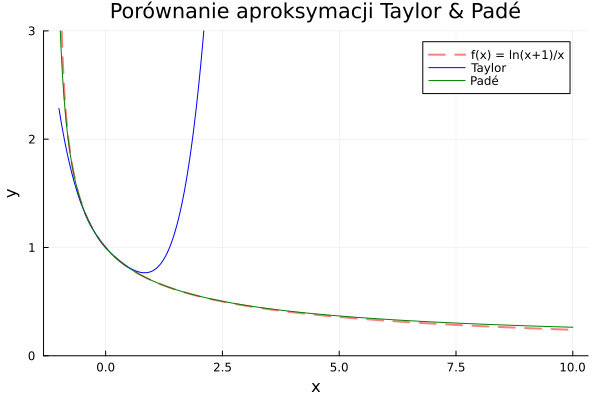